<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning Part 2: Fine-Tuning

### What we will cover
1. Introduce fine-tuning, a transfer learning approach to modify pre-trained layers to be more suited for our data.
2. Using the keras Functional API
3. Smaller dataset of faster experimentation
4. Data Augmenetation ( how to make our training dataset more diverse without adding more data).
5. Running a series of model experiments using our Food Vision data
    1. Model0: A transfer learning model using Keras functional api
    2. Model1: A feature extraction transfer learning model using 1% of the data with data augmentation
    3. Model2: A feature extraction transfer learning model using 10% of the data with data augmentation.
    4. Model3: A fine-tuned transfer learning model on 10% of data.
    5. Model4: A fine-tuned transfer learning model on 100% of data.
6. Introduce model checkpoints to save intermediate model results
7. Compare the model experiments using tensorboard.




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
print(f" Notebook last run (end-to-end) {datetime.datetime.now()}")

 Notebook last run (end-to-end) 2023-08-06 14:06:49.607010


In [3]:
import tensorflow as tf
print(f" Tensorflow version : {tf.__version__}")

 Tensorflow version : 2.12.0


In [4]:
%%writefile helper_functions.py
import matplotlib.pyplot as plt

def plot_loss_curve(history):
  """
    Plots the loss and accuracy curve for training and validation metrics
    Args:
      history(A History object):

  """
  epochs= range(len(history.history["loss"]))
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]

  plt.plot(epochs,loss,label="Train loss")
  plt.plot(epochs,val_loss,label="Test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  ## Plot Accuracy
  plt.figure()
  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]
  plt.plot(epochs,accuracy,label="Train Accuracy")
  plt.plot(epochs,val_accuracy, label="Test Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();



Writing helper_functions.py


In [5]:
## Download data and unzip it
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip



--2023-08-06 14:06:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  37.3MB/s    in 5.0s    

2023-08-06 14:06:59 (32.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
%%writefile -a helper_functions.py

import zipfile
import os
def unzip_data(zipped_file,remove_src_zip=True):
  """
    Takes a zipped file and unzips it.Removes the source zipfile.
  """
  zip_ref= zipfile.ZipFile(zipped_file,"r")
  zip_ref.extractall()
  zip_ref.close()
  os.remove(zipped_file)

Appending to helper_functions.py


In [7]:
from helper_functions import unzip_data
unzip_data("/content/10_food_classes_10_percent.zip")

In [8]:
!rm -r "/content/__MACOSX"

In [9]:
data_dir= "/content/10_food_classes_10_percent"

In [10]:
%%writefile -a helper_functions.py

def walk_through_dir(data_dir):
  for dirpath,dirnames,filenames in os.walk(data_dir):
    print(f" There are {len(filenames)} images and {len(dirnames)} folder at {dirpath}")



Appending to helper_functions.py


In [11]:
from helper_functions import walk_through_dir
walk_through_dir(data_dir)


 There are 0 images and 2 folder at /content/10_food_classes_10_percent
 There are 0 images and 10 folder at /content/10_food_classes_10_percent/test
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/chicken_wings
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/sushi
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/fried_rice
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/steak
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/grilled_salmon
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/ice_cream
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/chicken_curry
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/pizza
 There are 250 images and 0 folder at /content/10_food_classes_10_percent/test/ramen
 There are 250 images and 0 folder at /content/10_f

In [12]:
train_dir="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/train"


In [13]:
#Create data inputs
import tensorflow as tf

IMG_SIZE=(224,224)
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir
                                                                           ,labels="inferred"
                                                                           ,label_mode="categorical"
                                                                           ,image_size=IMG_SIZE
                                                                           ,shuffle=True
                                                                           )
test_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir
                                                                          ,labels="inferred"
                                                                          ,label_mode="categorical"
                                                                          ,image_size=IMG_SIZE
                                                                          )


Found 750 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


In [14]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [15]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [16]:
%%writefile -a helper_functions.py
import datetime
import tensorflow as tf
def create_tensorboard_callbacks(log_dir,experiment_name):
  log_dir = log_dir + "/" + experiment_name+ "/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

Appending to helper_functions.py


## Model 0: Build a Transfer Learning model using keras Functional API

Steps:
1. Instantiate a pre-trained base model object by choosing the target model as [EfficientNetB0]() from `tf.keras.applications` setting the `include_top` parameter to `False` ( as we will have our own output layers)
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model
3. Define an input layer for our model, what shape of data should our model expects.
4. Normalize the input to our model if needed.
5. Pass the input to the model.
6. Pool the output of the base model into a shape compatible with output activation layer ( turn base model output tensors to same shape as label tensors). This can be done using `tf.keras.layers.GlobalAveragePooling2d()` or `tf.keras.layers.GlobalMaxPooling2D()` though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with appropriate activation function and number of neurons.
8. Combine the input and out layers with `tf.keras.Model()`
9. Compile the model using appropriate loss function and optimizer.
10. Fit the model with desired number of epochs and necessary callbacks.

In [17]:
from helper_functions import create_tensorboard_callbacks
# 1. Instantiate a pre-trained EfficientNetB0 model disabling the top layers with include_top=False
effnetb0_model= tf.keras.applications.EfficientNetB0(include_top=False)
# 2. Set the base model trainable attribute to false to freeze all of the weights in pre-trained model
effnetb0_model.trainable= False
# 3. Define an output layer for our model
inputs= tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# 4. Normalize the input ( Not required as per this thread: https://github.com/tensorflow/tensorflow/issues/42506)

# 5. Pass the input to the model
x= effnetb0_model(inputs)

# 6. Pool the output of the base model inot a shape compatible with output activation layer
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# 7. Create the output activation layer
outputs= tf.keras.layers.Dense(len(train_data_10_percent.class_names),activation="softmax",name="output_layer")(x)
# 8. Combine the input and output layers
model= tf.keras.Model(inputs= inputs
                      ,outputs= outputs
                      ,name="effnetb0_pretrained")

# 9. Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy
              ,optimizer=tf.keras.optimizers.Adam()
              ,metrics=["accuracy"])
# 10. Fit the model with desired number of epochs and necessary callbacks.
effnetb0_history= model.fit(train_data_10_percent
                            ,steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data_10_percent
                            ,validation_steps=int(0.25 * len(test_data_10_percent))
                            ,epochs=5
                            ,callbacks=[create_tensorboard_callbacks(log_dir="transfer_learning",
                                                                     experiment_name="effnet_10_percent_feature_extract")])



16705208/16705208 [==============================] - 1s 0us/step


Epoch 1/5
24/24 [==============================] - 21s 246ms/step - loss: 1.9000 - accuracy: 0.3893 - val_loss: 1.3013 - val_accuracy: 0.7552
Epoch 2/5
24/24 [==============================] - 3s 106ms/step - loss: 1.1047 - accuracy: 0.7773 - val_loss: 0.8571 - val_accuracy: 0.8542
Epoch 3/5
24/24 [==============================] - 3s 106ms/step - loss: 0.7911 - accuracy: 0.8387 - val_loss: 0.6129 - val_accuracy: 0.8854
Epoch 4/5
24/24 [==============================] - 4s 150ms/step - loss: 0.6468 - accuracy: 0.8600 - val_loss: 0.5007 - val_accuracy: 0.9115
Epoch 5/5
24/24 [==============================] - 3s 107ms/step - loss: 0.5556 - accuracy: 0.8773 - val_loss: 0.4295 - val_accuracy: 0.9167


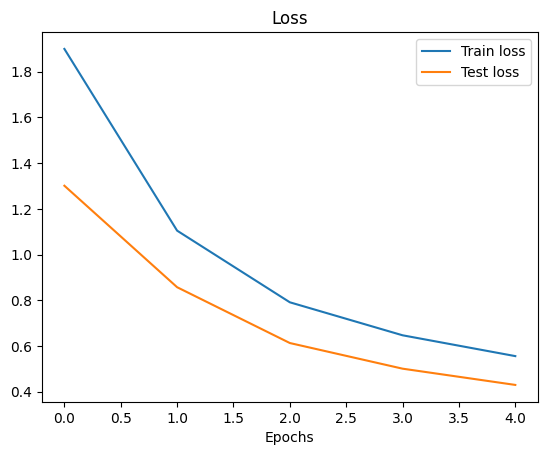

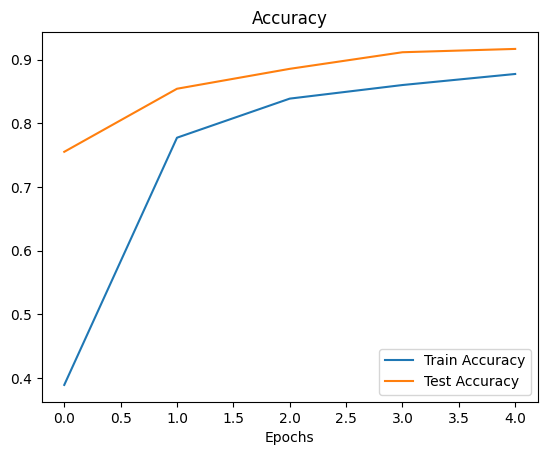

In [18]:
from helper_functions import plot_loss_curve
plot_loss_curve(effnetb0_history)

<Axes: >

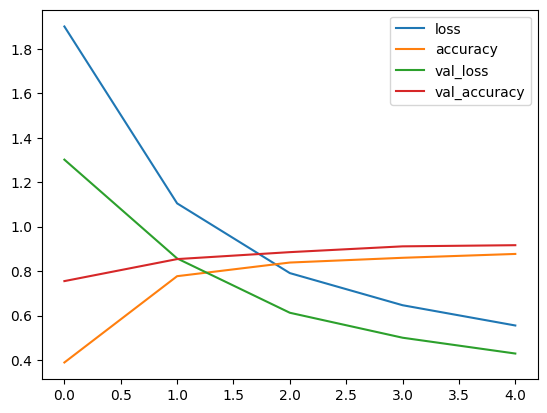

In [19]:
import pandas as pd
pd.DataFrame(effnetb0_history.history).plot()

### Running a series of Transfer Learning experiment
1. model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation
2. model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation
3. model_3: Use fine-tuning transfer learning with 10% of traning data and data augmentation
4. model_4: Use fine-tuning transfer learning with 100% of training data and data augmentation

In [20]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-08-06 14:07:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  35.7MB/s    in 3.8s    

2023-08-06 14:08:01 (33.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
unzip_data("/content/10_food_classes_1_percent.zip")

In [22]:
!rm -r /content/sample_data

In [23]:
!rm -r /content/__MACOSX

In [24]:
from IPython.lib.display import walk
train_dir_1_percent= "/content/10_food_classes_1_percent/train"
test_dir= "/content/10_food_classes_1_percent/test"
walk_through_dir(train_dir_1_percent)

 There are 0 images and 10 folder at /content/10_food_classes_1_percent/train
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/chicken_wings
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/sushi
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/fried_rice
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/steak
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/grilled_salmon
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/ice_cream
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/chicken_curry
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/pizza
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/ramen
 There are 7 images and 0 folder at /content/10_food_classes_1_percent/train/hamburger


Time to make our dataset available as instance of `tf.Data.Dataset` using `tf.keras.preprocessing.image_dataset_from_directory()`

In [25]:
train_data_1_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent
                                                                          ,labels="inferred"
                                                                          ,label_mode="categorical"
                                                                          ,shuffle=True
                                                                          ,image_size=IMG_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir
                                                               ,labels="inferred"
                                                               ,label_mode="categorical"
                                                               ,shuffle=True
                                                               ,image_size=IMG_SIZE
                                                               )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


We will use the `tf.keras.experimental.preprocessing` module and create data augmentation layer
> When passed as a layer to a model data augementation is automatically **turned on during training** (augments training data) but **turned off during inference** (does not augments testing or unseen data)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation= tf.keras.Sequential([
     layers.RandomFlip("horizontal")
    ,layers.RandomRotation(factor=0.2)
    ,layers.RandomZoom(height_factor=0.2)
    ,layers.RandomHeight(factor=0.2)
    ,layers.RandomWidth(factor=0.2)
    #,layers.Rescaling(scale=1./255) should be used with Resnet and removed in case of EfficientNetBo
],name="data_augmentation")

Let us see what are the effects of augmenation on a random image from our training dataset

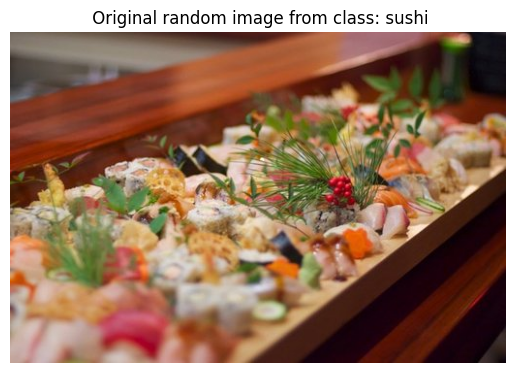

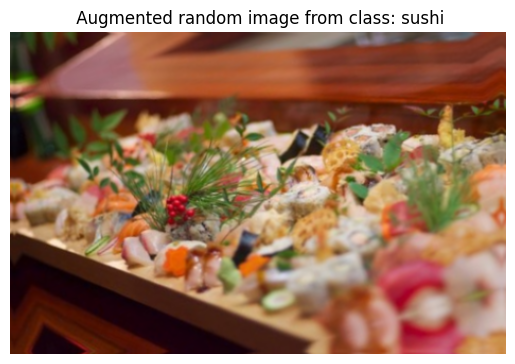

In [39]:
# Augment a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class= random.choice(train_data_1_percent.class_names)
target_dir= train_dir_1_percent+ "/"+target_class
random_image=  random.choice(os.listdir(target_dir))
random_image_path= target_dir + "/" +random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis(False)
plt.title(f" Original random image from class: {target_class}")

# augment the random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False)
plt.title(f" Augmented random image from class: {target_class}");



# Model 1: Feature extraction transfer learning on 1% data with data augmentation

In [40]:
# Setup input shape and base model, freezing the base layers
import tensorflow as tf
from tensorflow.keras import layers

input_shape= (224,224,3)
effnetb0_model= tf.keras.applications.EfficientNetB0(include_top=False)
effnetb0_model.trainable= False

# Create input layer
inputs= layers.Input(shape=input_shape,name="input_layer")

# Perform data augmentation
x= data_augmentation(inputs)

# Pass the augmented data through base model, but don't train it
x= effnetb0_model(x,training= False)

# Perform average pooling
x= layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)

# Put a dense layer on as the output
outputs= layers.Dense(len(train_data_1_percent.class_names)
                               ,activation="softmax"
                               ,name="output_layer")(x)

# Make the model
model_1= tf.keras.Model(inputs=inputs
                        ,outputs=outputs
                        ,name="effnetb0_model")

# compile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"])

# fit the model

model_1_history= model_1.fit(train_data_1_percent
                             ,steps_per_epoch=len(train_data_1_percent)
                             ,validation_data=test_data
                             ,validation_steps=int(0.25 * len(test_data))
                             ,epochs=5
                             ,callbacks=[create_tensorboard_callbacks(log_dir="transfer_learning"
                                                                      ,experiment_name="effnetbo_1_percent_data_augment")])




Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.4191 - accuracy: 0.0571 - val_loss: 2.2687 - val_accuracy: 0.1497
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1287 - accuracy: 0.2429 - val_loss: 2.1385 - val_accuracy: 0.2418
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9457 - accuracy: 0.4000 - val_loss: 2.0344 - val_accuracy: 0.3158
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8090 - accuracy: 0.4429 - val_loss: 1.9386 - val_accuracy: 0.3964
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6724 - accuracy: 0.6429 - val_loss: 1.8304 - val_accuracy: 0.4786


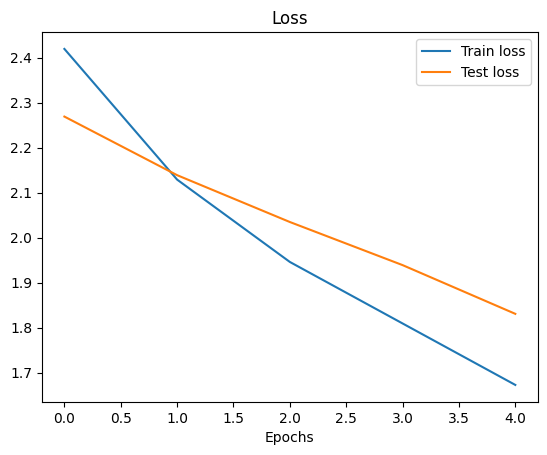

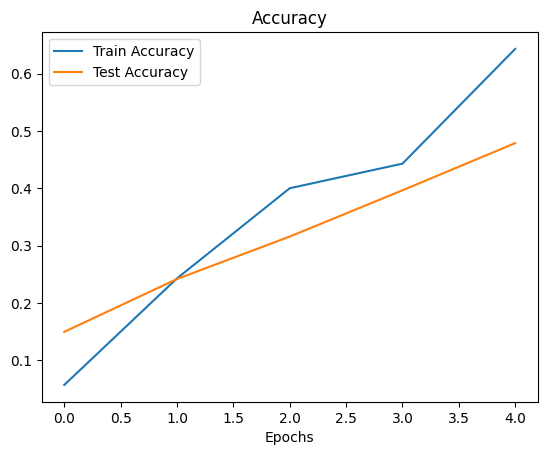

In [41]:
plot_loss_curve(model_1_history)

In [37]:
model_1.summary()

Model: "effnetb0_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_____________________________________